<a href="https://colab.research.google.com/github/rawat-nitin/ColabGoogleStuff/blob/main/AutoMPG_REGRESSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic Regression: Predict Fuel Efficiency.**

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an ornage, recognizing which fruit is in the picture).

This tutorial uses the classic Auto MPG dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s early 1980s automobiles. To d this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example used the Kera API.


In [ ]:
# Use seaborn for pairplot, it will help to create Statistical plot 
%pip install -q seaborn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Seaborn version: %s" %sns.__version__)
print("numpy version: %s" %np.__version__)
print("Pandas version: %s" %pd.__version__)


Seaborn version: 0.11.2
numpy version: 1.19.5
Pandas version: 1.1.5


In [ ]:
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print("Tensor flow version: %s" %tf.__version__)

Tensor flow version: 2.7.0


**THE AUTO MPG DATASET**
The dataset is available from the UCI https://archive.ics.uci.edu/ml/

**GET THE DATA**
First download and import the dataset using pandas: 

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Accelaration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [ ]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Accelaration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


**Clean the data**
The data-set contains a few unkown values:

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Accelaration    0
Model Year      0
Origin          0
dtype: int64

**What i isna?**

Detect missing values.
Return a boolean same-sized object indicating if the values are NA. NA values, such as None or numpy.NaN, gets maped to TRuevalues.
Everything else gets mapped to False values. Characters such as empty strings '' or numpy.inf are not considered NA values (unless you set pandas.options.mode.use_inf_as_na = True).

Drop those rows to keep this initial tutorial simple:

In [ ]:
dataset = dataset.dropna()
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Accelaration    0
Model Year      0
Origin          0
dtype: int64

The **"Origin"** column is categorical, not numeric. So the next step is one-hot encode the values in the column with pd.get_dummies.

**Note:** You an set up the tf.keras.Model to do this kind of transformation for you but that's beyond the scope of this tutorial. Check out the Classify strucutured data using Keras preprocessing layers or Load CSV data tutorial for examples.

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [ ]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Accelaration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


**Split the data into training and test sets**

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

**Inspect the Data**

Review the joint distribution of a few pairs of columns from the training set.
The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

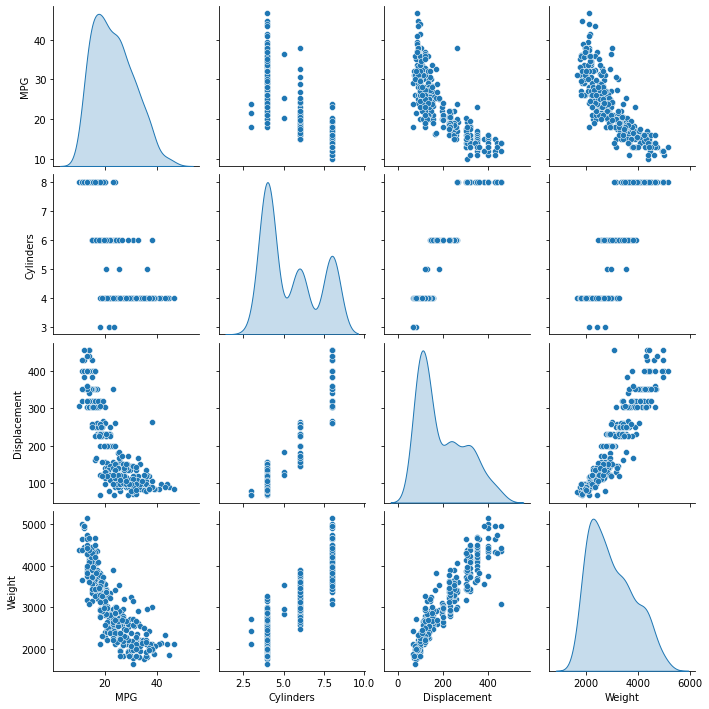

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Let's also check the overall statistics. Note how each features covers a very different range:

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Accelaration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


**Split features from labels**
Separate the target value-the "label"-from the features. This label is the value that you will train the model to predict

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

**Normalization**

In the table of stastics it's easy to see how different the ranges of each features are:*italicized text*

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Accelaration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


It is a good practice to normalize features that use different scales and ranges.
One reason this is important is beacuse the features are multiplied by the model weights. SO, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
Although a model might converge without feature normalization, normalization makes training more stable.

**Note:** There is no advantage to normalizing the one-hot features-it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the Working with preprocessing layers guide and the Classify strucutured data using Keras preprocessing layers tutorial.



**The Normalization layer**

The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.
The first step is to create the layer:

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:

In [ ]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [ ]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


**Linear Regression**

Before building a deep neural network model, start with linear regression using one and several variables.

Linear regression with one varibale **bold text**

Begin with a single-variable linear regression to predict **'MPG'** from **'Horseposer'**.

Training a model with tf.keras typically starts by defining the model architecture. Use a tf.keras.Sequential model, which represents a sequence of steps.

There are two steps in your single-variable linear regression model:

(1) Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.

(2) Apply a linear transformation (y = mx + b) to produce 1 output using a linear layer (tf.keras.layers.Dense).

The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the 'Horsepower' features. Then, instantiate the tf.keras.layers.Normalization and fit its state to the horsepower data:




In [ ]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Build the Keras Sequential model:

In [ ]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer, layers.Dense(units=1)])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict 'MPG' from 'Horsepower'.
Run the untained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has expected shape of (10, 1):

In [ ]:
horsepower_model.predict(horsepower[:10])

array([[ 0.078],
       [ 0.044],
       [-0.145],
       [ 0.11 ],
       [ 0.099],
       [ 0.039],
       [ 0.118],
       [ 0.099],
       [ 0.026],
       [ 0.044]], dtype=float32)

Once the model is built, configure the training procedure using the Keras Model.compile method. The most importnant arguements to compile are the loss and the optimizer, since these defines what will be optimized (mean_abosolute_error) and how (using the tf.keras.optimizers.Adam).



In [ ]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Having configures the training configures, use Keras Model.fit to execute the training for 100 epochs:

In [ ]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Supress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.39 s, sys: 157 ms, total: 3.55 s
Wall time: 3.41 s


Visulaize the model's training progress using the stats in the history object:

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804239,4.202983,95
96,3.802321,4.182214,96
97,3.803803,4.171543,97
98,3.807239,4.191270,98
99,3.802193,4.194252,99


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel(['Epoch'])
  plt.ylabel(['Error [MPG]'])
  plt.legend()
  plt.grid(True)

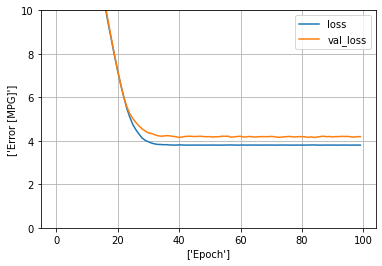

In [ ]:
plot_loss(history)

Collect the results on the test set for later:

In [ ]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'], 
    test_labels, verbose=0)

Since this is a single varibale regression, it's easy to view the model's predictions as a function of the input:

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [ ]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

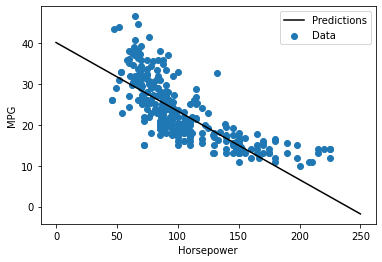

In [ ]:
plot_horsepower(x, y)

**Linear regression with multiple inputs**

You can use an almost identical setup to make predictions based on mulitple inputs. This model still does the same y = mx + b except that m is a matric and b is a vector.

Create a two-step Keras Sequential model again with the first layer being normalizer (tf.keras.layers.NOrmalization(axis=-1) you defined earlier and adapted to the whole dataset:

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call Model.predict on a batch of inputs, it produces units=1 outputs for each exmple:

In [ ]:
linear_model.predict(train_features[:10])

array([[-0.038],
       [ 0.748],
       [-1.351],
       [ 0.543],
       [ 1.705],
       [ 0.386],
       [ 1.894],
       [ 1.262],
       [-0.132],
       [ 1.403]], dtype=float32)

When  you call the model, its weight matrices will be built-check that the kernel weights (the m in y = mx+b) have a shape of (9, 1):

In [ ]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.607],
       [ 0.586],
       [-0.195],
       [-0.225],
       [ 0.524],
       [ 0.182],
       [-0.55 ],
       [-0.118],
       [-0.488]], dtype=float32)>

Configure the model with Keras MOdel.compile and train with Model.fit for 100 epochs:

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features, 
    train_labels,
    epochs=100,
    # Supress logging
    verbose=0,
    # Calculation validation results on 0% of the training data.
    validation_split = 0.2)

CPU times: user 3.2 s, sys: 164 ms, total: 3.36 s
Wall time: 3.04 s


Using all the inputs in this regression model achieves a much lower training and validation error than the horsepower_model, which had one input:

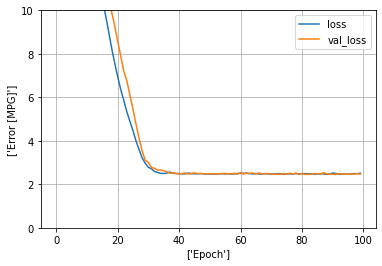

In [ ]:
plot_loss(history)

Collect the results on the test set for later:

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

**Regression with a deep neural network (DNN)**

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.
The code is bascally the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.
These models will contain a few more layers than the linear model:

(1) The normalization layer, as before (with **horsepower_normalizer** for a single-input model and **normalizer** for a multiple-input model).

(2) Two hidden, non-linear, **Dense** layers with ReLU (relu) activation function nonlinearity.

(3) A linear Dense single-ouput layer.

Both models will use the same training prcedure so the **compile** method is included in the **build_and_compile_model** function below.

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

**Regression using a DNN and a Single input**

Create a DNN model with only 'Horsepower' as input and horsepower_normalizer (defined earlier) as the normalizatio layer:

In [ ]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [ ]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model with Keras Model.fit:

In [ ]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.68 s, sys: 203 ms, total: 3.89 s
Wall time: 3.49 s


This model does slighlty better than the single-input **horsepower_model**:

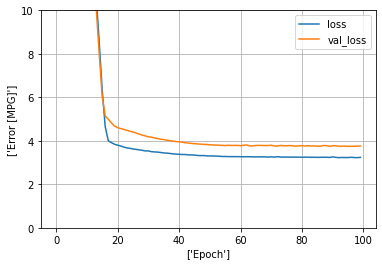

In [ ]:
plot_loss(history)

If you plot the predictions as a function of 'Horsepower', you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

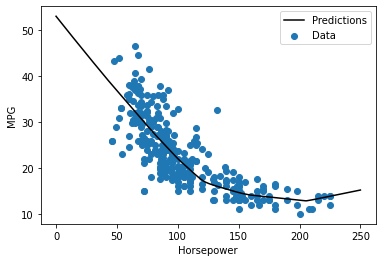

In [ ]:
plot_horsepower(x, y)

Collect the results on the test set for later:

In [ ]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

**Regression using a DNN and multiple inputs**

Repeat the previous process using all the inputs. The model's performance slightly inproves on the validation dataset.

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.81 s, sys: 209 ms, total: 4.01 s
Wall time: 3.57 s


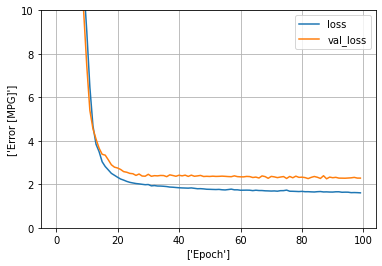

In [ ]:
plot_loss(history)

Collect the results on the test set:

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

**Performance**

Since all models have been trained, you can review their test set performance:

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648792
linear_model,2.410669
dnn_horsepower_model,2.828630
dnn_model,1.684393


These results match the validation error observed during training.

**Make predictions**

You can now make prediction with the dnn_model on the test set using Keras Model.predict and review the loss:

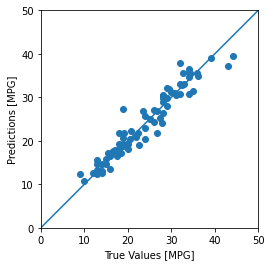

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims) 
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

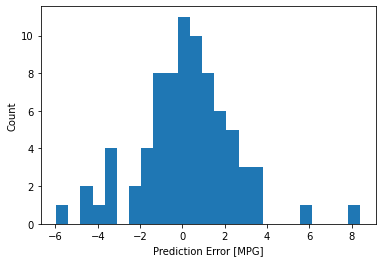

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you are happy with the model, save it for later use wit Model.save:

In [ ]:
dnn_model.save('dnn_model_mpg')

INFO:tensorflow:Assets written to: dnn_model_mpg/assets


If you reload the model, it gives identical ouput:

In [ ]:
reloaded = tf.keras.models.load_model('dnn_model_mpg')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648792
linear_model,2.410669
dnn_horsepower_model,2.828630
dnn_model,1.684393
reloaded,1.684393


**Conclusion**

This notebook introduced a few techniques to handle a regression problem. Here are few tips that may help:

(a) Mean squared error (MSE) (tf.losses.MeanMeanSquaredError) and mean absolute error (MAE) (tf.losses.MeanAbsoluteError) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss function are used for classification problems.

(b) Similarly, evaluation metrics used for regression differ from classification.

(c) When numeric input data features have values with different ranges, each feature suhould be scaled independently to the same range.

(d) Overfitting is a common problem for DNNmoesl, though it wasn't a problem for this tutorial. Visit the Overfit and Underfit tutorial for more help with this.

Overfit and Underfit: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit
